# CS634 Data Mining - Term Project

Table of Contents:
- [Part 1: Modules, Data Imports, and Functions](#part-1-modules-data-imports-and-functions)
- [Part 2: Exploratory Analysis](#part-2-exploratory-analysis)
- [Part 3: Data Cleaning and Preprocessing](#part-3-data-cleaning-and-preprocessing)
- [Part 4: Decision Tree Classifier](#part-4-decision-tree-classifier)
- [Part 5: Logistic Regression Model](#part-5-logistic-regression-model)
- [Part 6: Conclusion](#part-6-conclusion)

### Part 1: Modules, Data Imports, and Functions

In [24]:
#Avoid unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#General Python Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

#Decision Tree Modules
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

#Logistic Regression Module
from sklearn import linear_model

#Classification Imbalance
from imblearn.over_sampling import RandomOverSampler

#Load Raw Data
pitching_raw = pd.read_csv("Pitching.csv")
allstar_raw = pd.read_csv("AllstarFull.csv")

In [25]:
#Functions
def perNine(row,stat1,stat2):
    value = row[stat1]/row[stat2]
    return value

### Part 2: Exploratory Analysis

In [26]:
pitching_raw.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,...,NaN,NaN,NaN,0,NaN,NaN,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,...,NaN,NaN,NaN,0,NaN,NaN,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,...,NaN,NaN,NaN,0,NaN,NaN,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,...,NaN,NaN,NaN,0,NaN,NaN,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,...,NaN,NaN,NaN,0,NaN,NaN,21,NaN,NaN,NaN


In [27]:
pitching_raw.isnull().sum()

playerID        0
yearID          0
stint           0
teamID          0
lgID          131
W               0
L               0
G               0
GS              0
CG              0
SHO             0
SV              0
IPouts          1
H               0
ER              0
HR              0
BB              0
SO              0
BAOpp        1525
ERA            90
IBB         14575
WP            133
HBP           559
BK              0
BFP           239
GF            133
R               0
SH          32900
SF          32900
GIDP        43394
dtype: int64

In [28]:
allstar_raw.head()

,playerID,yearID,gameNum,gameID,teamID,lgID,GP,startingPos
0,gomezle01,1933,0,ALS193307060,NYA,AL,1.0,1.0
1,ferreri01,1933,0,ALS193307060,BOS,AL,1.0,2.0
2,gehrilo01,1933,0,ALS193307060,NYA,AL,1.0,3.0
3,gehrich01,1933,0,ALS193307060,DET,AL,1.0,4.0
4,dykesji01,1933,0,ALS193307060,CHA,AL,1.0,5.0


In [29]:
allstar_raw.isnull().sum()

playerID          0
yearID            0
gameNum           0
gameID           49
teamID            0
lgID              0
GP               19
startingPos    3489
dtype: int64

We see immediately that there are a significant number of nulls in certain columns of both tables, likely because several of these stats were not tracked until the modern era of baseball. We also see that all star game information does not begin until 1933 (the year of the first all star game). Combining this information with some intuition regarding the significance of some of these more niche statistics, the first step of cleaning will be to filter for relevant data without a significant number of nulls.

### Part 3: Data Cleaning and Preprocessing

To begin, I need create some new columns to represent some important statistics on a per game basis. This is going to include stats like strikeouts per nine innings, walks per nine innings, etc. The goal is to get a dataset that looks like:

playerID | yearID | Win/Game | K/9 | BB/9 | Hits/9 | ERA | BAOpp

Before this, I need to filter the data to match the all star information (yearID >= 1933) and clean up the data.

Step 1 of cleaning is to select the columns I intend to use and get rid of rows with yearID's pre-1933.

In [30]:
pitching_clean = pitching_raw.copy()

#Filter for relevant years
pitching_clean = pitching_clean[pitching_clean['yearID'] >= 1933]

#Select columns to work with
cols = ['playerID','yearID','W','L','G','CG','IPouts','H','BB','SO','BAOpp','ERA']
pitching_clean = pitching_clean[cols]

#Visualize nulls
print("-----------------------------------------------")
print(f'Total number of rows: {len(pitching_clean)}\n\nNulls in each column:')
print(pitching_clean.isnull().sum())

#Drop nulls
print("-----------------------------------------------")
pitching_clean = pitching_clean.dropna()
print(f'Total number of rows: {len(pitching_clean)}\n\nNulls in each column after drop:')
print(pitching_clean.isnull().sum())
print("-----------------------------------------------")

-----------------------------------------------
Total number of rows: 34809

Nulls in each column:
playerID      0
yearID        0
W             0
L             0
G             0
CG            0
IPouts        1
H             0
BB            0
SO            0
BAOpp       641
ERA          55
dtype: int64
-----------------------------------------------
Total number of rows: 34121

Nulls in each column after drop:
playerID    0
yearID      0
W           0
L           0
G           0
CG          0
IPouts      0
H           0
BB          0
SO          0
BAOpp       0
ERA         0
dtype: int64
-----------------------------------------------


In [31]:
pitching_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34121 entries, 9330 to 44138
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   playerID  34121 non-null  object 
 1   yearID    34121 non-null  int64  
 2   W         34121 non-null  int64  
 3   L         34121 non-null  int64  
 4   G         34121 non-null  int64  
 5   CG        34121 non-null  int64  
 6   IPouts    34121 non-null  float64
 7   H         34121 non-null  int64  
 8   BB        34121 non-null  int64  
 9   SO        34121 non-null  int64  
 10  BAOpp     34121 non-null  float64
 11  ERA       34121 non-null  float64
dtypes: float64(3), int64(8), object(1)
memory usage: 3.4+ MB


In [32]:
pitching_clean.head()

,playerID,yearID,W,L,G,CG,IPouts,H,BB,SO,BAOpp,ERA
9330,allenjo02,1933,15,7,25,10,554.0,171,87,119,0.24,4.39
9331,andreiv01,1933,7,13,34,5,420.0,157,61,37,0.27,4.95
9332,applepe01,1933,0,0,1,0,6.0,3,1,0,0.37,0.00
9333,aukerel01,1933,3,3,15,2,165.0,63,25,17,0.28,5.24
9334,barredi01,1933,4,4,15,3,211.0,74,49,26,0.27,5.76


I'm now left with 34,121 rows to work with. 

The next step is to add a boolean column for whether or not they were selected to the all star team. I can be a little tricky here by merging the two datasets based on playerID and yearID and then creating a column that checks for nulls in the gameID. If nulls exist, there was no gameID for the player in that year and so they weren't an all star.

In [33]:
#Merge dataframes
pitching_allstar = pd.merge(pitching_clean,allstar_raw,how='left',left_on=['playerID','yearID'], right_on = ['playerID','yearID'])

#Generate classification
pitching_allstar['AllStar'] = np.where(pitching_allstar['gameID'].isna(), 0, 1 )

#Select columns to work with
cols = ['playerID','yearID','W','L','G','CG','IPouts','H','BB','SO','ERA','BAOpp','AllStar']
pitching_allstar = pitching_allstar[cols]
pitching_allstar.head()

,playerID,yearID,W,L,G,CG,IPouts,H,BB,SO,ERA,BAOpp,AllStar
0,allenjo02,1933,15,7,25,10,554.0,171,87,119,4.39,0.24,0
1,andreiv01,1933,7,13,34,5,420.0,157,61,37,4.95,0.27,0
2,applepe01,1933,0,0,1,0,6.0,3,1,0,0.00,0.37,0
3,aukerel01,1933,3,3,15,2,165.0,63,25,17,5.24,0.28,0
4,barredi01,1933,4,4,15,3,211.0,74,49,26,5.76,0.27,0


We now have a clean dataset with which I can condense/create some more descriptive stats.

In [44]:
#Create new column using IPouts to represent 9 inning intervals --> drop IPouts
print("-----------------------------------------------")
pitchingDF = pitching_allstar.copy()
pitchingDF['NineInnings'] = pitchingDF['IPouts'].div(27)
pitchingDF = pitchingDF.drop(['IPouts'],axis=1)
print("Before:\n",pitchingDF.head())
print("-----------------------------------------------")

#Apply the perNine() function to each row to create more descriptive columns
pitchingDF['Wins_9'] = pitchingDF.apply(lambda row: perNine(row,'W','NineInnings'),axis=1)
pitchingDF['Losses_9'] = pitchingDF.apply(lambda row: perNine(row,'L','NineInnings'),axis=1)
pitchingDF['K_9'] = pitchingDF.apply(lambda row: perNine(row,'SO','NineInnings'),axis=1)
pitchingDF['BB_9'] = pitchingDF.apply(lambda row: perNine(row,'BB','NineInnings'),axis=1)
pitchingDF['Hits_9'] = pitchingDF.apply(lambda row: perNine(row,'H','NineInnings'),axis=1)

#Select columns for use in model creation
cols = ['playerID','yearID','Wins_9','Losses_9','K_9','BB_9','Hits_9','CG','ERA','AllStar']
pitchingDF_final = pitchingDF.copy()
pitchingDF_final = pitchingDF_final[cols]
print("After:\n",pitchingDF_final)
print("-----------------------------------------------")

-----------------------------------------------
Before:
     playerID  yearID   W   L   G  CG    H  BB   SO   ERA  BAOpp  AllStar  \
0  allenjo02    1933  15   7  25  10  171  87  119  4.39   0.24        0   
1  andreiv01    1933   7  13  34   5  157  61   37  4.95   0.27        0   
2  applepe01    1933   0   0   1   0    3   1    0  0.00   0.37        0   
3  aukerel01    1933   3   3  15   2   63  25   17  5.24   0.28        0   
4  barredi01    1933   4   4  15   3   74  49   26  5.76   0.27        0   

   NineInnings  
0    20.518519  
1    15.555556  
2     0.222222  
3     6.111111  
4     7.814815  
-----------------------------------------------
After:
         playerID  yearID    Wins_9  Losses_9        K_9      BB_9     Hits_9  \
0      allenjo02    1933  0.731047  0.341155   5.799639  4.240072   8.333935   
1      andreiv01    1933  0.450000  0.835714   2.378571  3.921429  10.092857   
2      applepe01    1933  0.000000  0.000000   0.000000  4.500000  13.500000   
3      a

At this point I have a good starting point for a dataset to analyze. To confirm  accuracy, I'll check the info for Max Scherzer, an all star pitcher from 2013-2015.

In [35]:
pitchingDF_final[pitchingDF_final['playerID'] == 'scherma01']

,playerID,yearID,Wins_9,Losses_9,K_9,BB_9,Hits_9,CG,ERA,AllStar
28937,scherma01,2008,0.000000,0.642857,10.607143,3.375000,7.714286,0,3.05,0
29650,scherma01,2009,0.475538,0.581213,9.193738,3.328767,8.771037,0,4.12,0
30351,scherma01,2010,0.551959,0.505963,8.463373,3.219761,8.003407,0,3.50,0
31052,scherma01,2011,0.692308,0.415385,8.030769,2.584615,9.553846,0,4.43,0
31783,scherma01,2012,0.767318,0.335702,11.078153,2.877442,8.584369,0,3.74,0
32513,scherma01,2013,0.881804,0.125972,10.077760,2.351477,6.382582,0,2.90,1
33240,scherma01,2014,0.735250,0.204236,10.293495,2.573374,8.006051,1,3.15,1
34050,scherma01,2015,0.551020,0.472303,10.862974,1.338192,6.927114,4,2.79,1


And we can see that the data is accurate which gives me good confidence going forward. The first model I want to try is a decision tree model. This will use breakdowns of the features I created to predict whether or not they were selected to an all star game.

### Part 4: Decision Tree Classifier

In [36]:
#Define features and classifier for training and prediction
features = ['Wins_9','Losses_9','K_9','BB_9','Hits_9','CG','ERA']

X = pitchingDF_final[features]
Y = pitchingDF_final['AllStar']

#Normalize data by year such that performance is relative to other players in the same year
normalized_DF = pitchingDF_final.loc[ : , pitchingDF_final.columns != 'AllStar'].groupby('yearID').transform(lambda x: (x - x.mean()) / x.std())
normalized_DF['AllStar'] = pitchingDF_final['AllStar']

X_norm = normalized_DF[features]
Y_norm = normalized_DF['AllStar']

##### Non-normalized data

-----------------------------------------------
Evaluation -
Accuracy: 93.24%
f1 score: 0.33
-----------------------------------------------


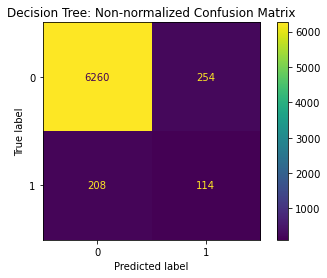

-----------------------------------------------


In [37]:
#Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

#Create decision tree
pitching_DecisionTree = DecisionTreeClassifier()

#Training
pitching_DecisionTree = pitching_DecisionTree.fit(X_train,y_train)

#Prediction
prediction = pitching_DecisionTree.predict(X_test)

print("-----------------------------------------------\nEvaluation -")
#Test Accuracy
print("Accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

#f1 score
print('f1 score:',round(f1_score(y_test, prediction),3))
print("-----------------------------------------------")

#Confusion matrix
cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pitching_DecisionTree.classes_)
disp.plot()
disp.ax_.set_title("Decision Tree: Non-normalized Confusion Matrix")
plt.show()
print("-----------------------------------------------")

This is pretty good accuracy already, but I want to consider the possibility that all star selection is relative to performance within a given year. That is, if I normalize the data by year such that the features measure success relative to other players during the same year, will accuracy improve?

##### Normalized Data

-----------------------------------------------
Evaluation -
Accuracy with normalization: 92.72%
f1 score: 0.327
-----------------------------------------------


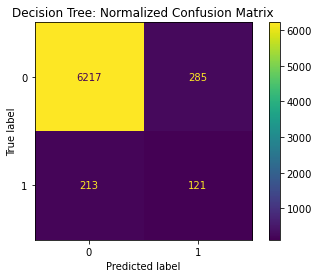

-----------------------------------------------


In [38]:
#Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X_norm, Y_norm, test_size=0.2, random_state=0)

#Create decision tree
pitching_DecisionTree_normByYear = DecisionTreeClassifier()

#Training 
pitching_DecisionTree_normByYear = pitching_DecisionTree_normByYear.fit(X_train,y_train)

#prediciton
prediction = pitching_DecisionTree_normByYear.predict(X_test)

print("-----------------------------------------------\nEvaluation -")
#Test accuracy
print("Accuracy with normalization: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

#f1 score
print('f1 score:',round(f1_score(y_test, prediction),3))
print("-----------------------------------------------")

#Confusion matrix
cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pitching_DecisionTree_normByYear.classes_)
disp.plot()
disp.ax_.set_title("Decision Tree: Normalized Confusion Matrix")
plt.show()
print("-----------------------------------------------")

To be honest, I expected this to improve the accuracy, but it was pretty ineffectual. I'm going to check if the data is imbalanced and, if so, oversample the smaller class to try to account for it.

In [39]:
print("-----------------------------------------------")
numAllStars = pitching_allstar['AllStar'].sum()
print(f'The total number of True values in the AllStar column is {numAllStars}\nThis is {round(numAllStars/len(pitching_allstar),3)*100}% of all values.')
print("-----------------------------------------------")

-----------------------------------------------
The total number of True values in the AllStar column is 1642
This is 4.8% of all values.
-----------------------------------------------


##### Oversampled Data

-----------------------------------------------
Initial classification split:  Counter({0: 32537, 1: 1642})
Oversampled classification split:  Counter({0: 32537, 1: 16268})
-----------------------------------------------
Evaluation -
Accuracy with oversampling: 97.51%
f1 score: 0.964
-----------------------------------------------


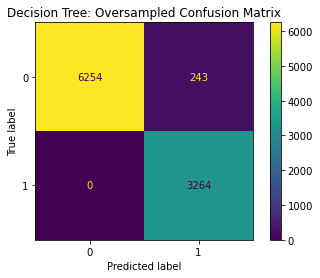

-----------------------------------------------


In [45]:
#Check the initial training data balance --> oversample --> recheck balance
print("-----------------------------------------------")
print("Initial classification split: ", Counter(Y))

oversample = RandomOverSampler(sampling_strategy=0.5)

x_over, y_over = oversample.fit_resample(X_norm,Y_norm)

print("Oversampled classification split: ", Counter(y_over))

#Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=1)

#Create decision tree
pitching_DecisionTree_Oversample = DecisionTreeClassifier()

#Training
pitching_DecisionTree_Oversample = pitching_DecisionTree_Oversample.fit(X_train,y_train)

#Prediction
prediction = pitching_DecisionTree_Oversample.predict(X_test)

print("-----------------------------------------------\nEvaluation -")
#Test Accuracy
print("Accuracy with oversampling: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

#f1 score
print('f1 score:',round(f1_score(y_test, prediction),3))
print("-----------------------------------------------")

#Confusion matrix
cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pitching_DecisionTree_Oversample.classes_)
disp.plot()
disp.ax_.set_title("Decision Tree: Oversampled Confusion Matrix")
plt.show()
print("-----------------------------------------------")

This is much better! Evident in the confusion matrix is the very significant reduction in false negatives, as well as a smaller reduction in false positives. Additionally, the f1 score is much better, meaning the model performs better on the smaller class.

### Part 5: Logistic Regression Model
Out of curiosity, I want to see if a logistic regression model can achieve higher accuracy than the decision tree. I'm going to try it first with the base data, then the normalized data, and finally using the built in class_weight=balance to account for class imbalance.

##### Non-nomalized Data

-----------------------------------------------
Evaluation -
Accuracy : 95.29%
f1 score: 0.278
-----------------------------------------------


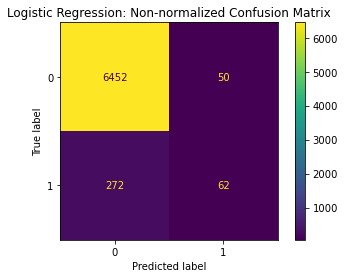

-----------------------------------------------


In [41]:
#Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#Create logistic regression object
pitching_LogisticRegression = linear_model.LogisticRegression()

#Training
pitching_LogisticRegression.fit(X_train,y_train)

#Prediction
prediction = pitching_LogisticRegression.predict(X_test)

print("-----------------------------------------------\nEvaluation -")
#Test accuracy
print ("Accuracy : {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

#f1 score
print('f1 score:',round(f1_score(y_test, prediction),3))
print("-----------------------------------------------")

#Confusion matrix
cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pitching_LogisticRegression.classes_)
disp.plot()
disp.ax_.set_title("Logistic Regression: Non-normalized Confusion Matrix")
plt.show()
print("-----------------------------------------------")

##### Normalized Data

-----------------------------------------------
Evaluation -
Accuracy : 95.44%
f1 score: 0.307
-----------------------------------------------


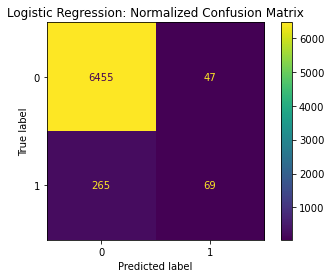

-----------------------------------------------


In [42]:
#Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X_norm, Y_norm, test_size=0.2, random_state=0)

#Create logistic regression object
pitching_LogisticRegression_normByYear = linear_model.LogisticRegression()

#Training
pitching_LogisticRegression_normByYear.fit(X_train,y_train)

#Prediction
prediction = pitching_LogisticRegression_normByYear.predict(X_test)

print("-----------------------------------------------\nEvaluation -")
#Test accuracy
print ("Accuracy : {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

#f1 score
print('f1 score:',round(f1_score(y_test, prediction),3))
print("-----------------------------------------------")

#Confusion matrix
cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pitching_LogisticRegression_normByYear.classes_)
disp.plot()
disp.ax_.set_title("Logistic Regression: Normalized Confusion Matrix")
plt.show()
print("-----------------------------------------------")


##### Balanced Data

-----------------------------------------------
Evaluation -
Accuracy : 81.29%
f1 score: 0.303
-----------------------------------------------


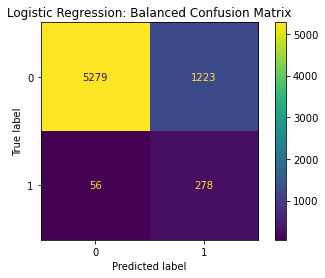

-----------------------------------------------


In [43]:
#Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#Create logistic regression object
pitching_LogisticRegression_Balanced = linear_model.LogisticRegression(class_weight='balanced')

#Training
pitching_LogisticRegression_Balanced.fit(X_train,y_train)

#Prediction
prediction = pitching_LogisticRegression_Balanced.predict(X_test)

print("-----------------------------------------------\nEvaluation -")
#Test accuracy
print ("Accuracy : {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

#f1 score
print('f1 score:',round(f1_score(y_test, prediction),3))
print("-----------------------------------------------")

#Confusion matrix
cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pitching_LogisticRegression_Balanced.classes_)
disp.plot()
disp.ax_.set_title("Logistic Regression: Balanced Confusion Matrix")
plt.show()
print("-----------------------------------------------")

Interestingly, we see that the accuracy of the model is high without accounting for class imbalance. However, the f1 score is fairly low, suggesting it doesn't do well with the smaller class. Balancing the class weight hardly affects the f1 score and sacrifices model accuracy in exchange.

### Part 6: Conclusion
I mentioned in my midway status report that model choice was slowing me down as I was unsure how to proceed without a chosen model in mind. I'm happy with my decision to heavily curate the data first and test a few different models afterwards. Using a combination of accuracy, f1 score, and confusion matrix analysis, it became clear in the end that a decision tree classifier was best suited for this data. Improving upon both the accuracy and f1 score via oversampling the smaller class was a key distinguishing factor between these models, as it became clear that a decision tree worked better to balance the classes. It might be worth it to note as well that I attempted a clustering model that did show a cluster of results, however the need for a principle component analysis to dimension reduce the data made the model uninterpretable. If I want to do something like this in the future, I'd likely need to condense the data first into something more indicative of overall performance so that a 2D or 3D representation of the data is readable. I've chosen to exclude this block of code since it became somewhat irrelevant.

I'd be curious to see how this model performs with live data. One of the reasons I used the normalized data in the oversampled model was because all star selection happens mid season and so performance relative to peers would be more generalizable than full season aggregate stats when applying this model.

In the future, more stats may be added to further increase the accuracy of this model. One issue with this is that new stats may not be retroactively available for players in the early-mid 1900s, suggesting that a model the excludes outdated data may function better. 